In [1]:
#%% -------- 1. Configuration Cell --------
import lightning.pytorch as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os
import splitfolders
from torch.optim.lr_scheduler import OneCycleLR
import torchmetrics
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Hardware config
NUM_CLASSES = 1  # Binary classification
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
PRECISION = '16-mixed'
EPOCHS = 50
LR = 1e-5
WARMUP_EPOCHS = 3
DATA_ROOT = "C:\\Users\\DELL 5540\\Desktop\\Brachial Plexus\\1st Classification"
SPLIT_ROOT = "C:\\Users\\DELL 5540\\Desktop\\Brachial Plexus\\Split_Dataset"
SEED = 42

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
pl.seed_everything(SEED)

Seed set to 42


42

In [2]:
#%% -------- 2. Data Preparation Cell --------
def prepare_dataset():
    splitfolders.ratio(
        DATA_ROOT,
        output=SPLIT_ROOT,
        seed=SEED,
        ratio=(0.7, 0.15, 0.15),
        group_prefix=None,
        move=False
    )

if not os.path.exists(os.path.join(SPLIT_ROOT, 'train')):
    prepare_dataset()

# MRI-specific transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets from split directories
train_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'val'), val_transform)
test_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'test'), val_transform)

# Class balancing
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32)
samples_weights = class_weights[train_dataset.targets]
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

Copying files: 970 files [00:01, 930.18 files/s]


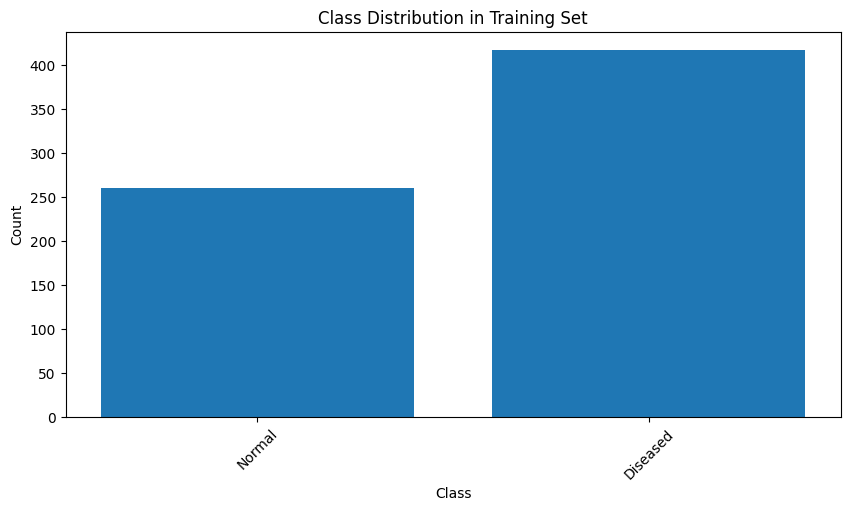

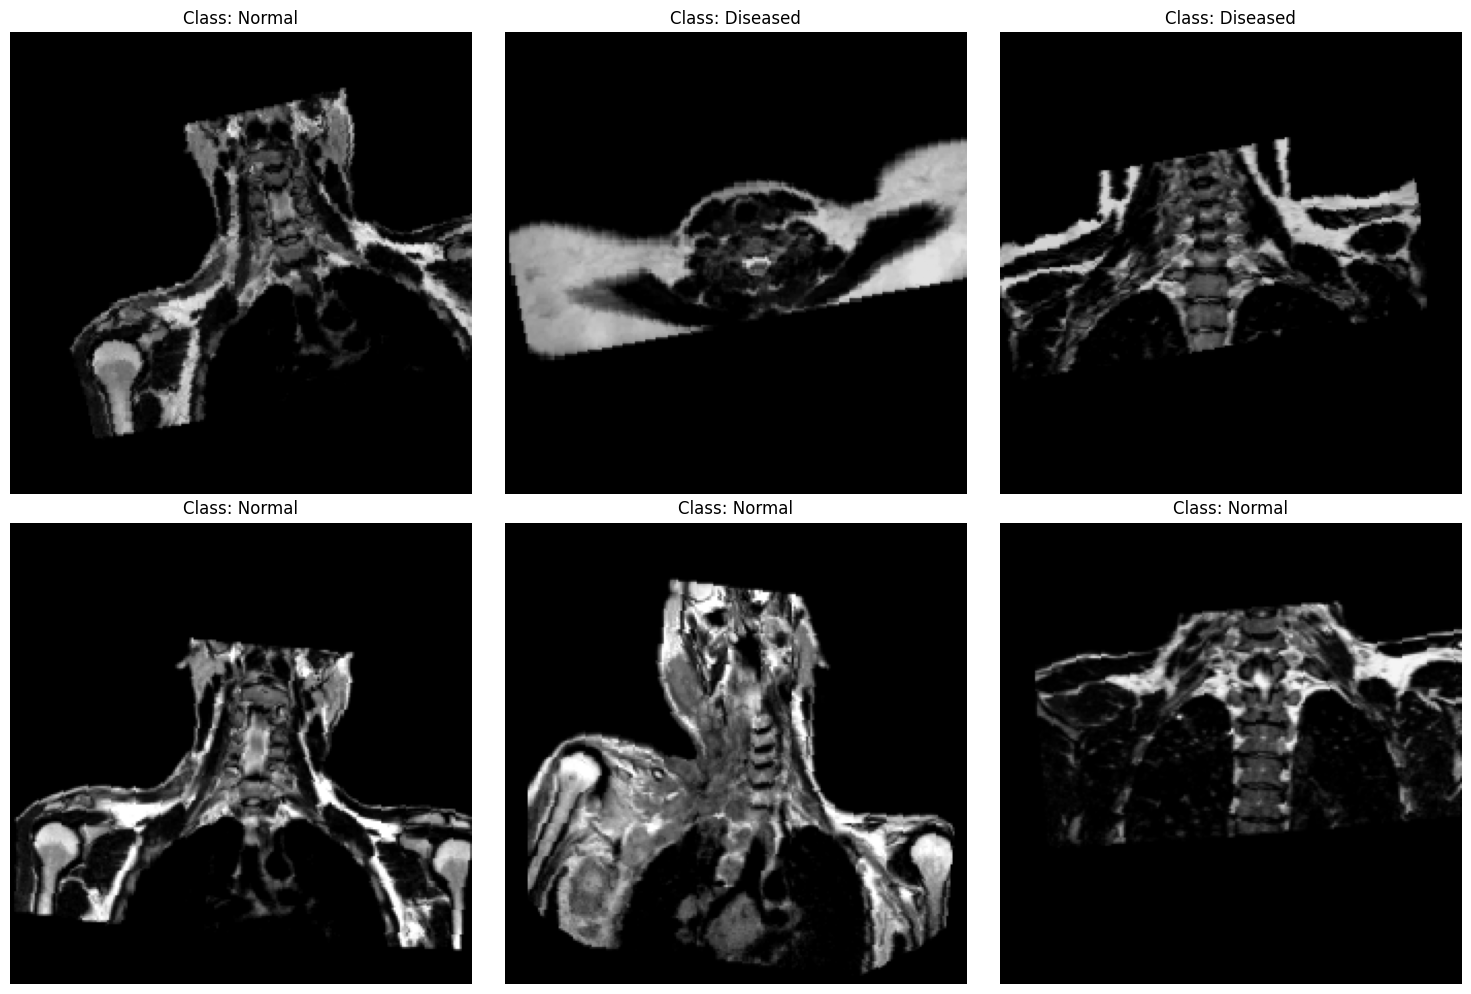

In [3]:
#%% -------- 3. Data Visualization Cell --------
class_names = ['Normal', 'Diseased']  # Manual mapping based on folder names

def plot_class_distribution():
    counts = np.bincount(train_dataset.targets)
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, counts)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

def show_sample_images(dataset, num_images=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        plt.subplot(2, 3, i+1)
        plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f"Class: {class_names[label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_class_distribution()
show_sample_images(train_dataset)

In [4]:
#%% -------- 4. ResMT Model Definition Cell --------
class BrachialPlexusResMT(nn.Module):
    def __init__(self, img_size=224, patch_size=32,  # Changed from 16 to 32
                 embed_dim=512, num_heads=8, num_layers=6, dropout=0.1):
        super().__init__()
        
        # ResNet-50 Backbone
        self.cnn_backbone = models.resnet50(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(self.cnn_backbone.children())[:-2])
        
        # Feature adaptation
        self.feature_adapt = nn.Sequential(
            nn.Conv2d(2048, embed_dim, 1),
            nn.BatchNorm2d(embed_dim),
            nn.GELU()
        )
        
        # Positional Encoding (7x7 grid from ResNet output)
        self.positional_encoding = nn.Parameter(
            torch.randn(49, 1, embed_dim))  # Corrected shape
        
        # Transformer Encoder
        encoder_layers = TransformerEncoderLayer(
            embed_dim, num_heads, dim_feedforward=2048, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        
        # Classification Head
        # Classification Head (REMOVED SIGMOID)
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 1)  # Output logits
        )
        
        # Freezing strategy
        for param in self.cnn_backbone.parameters():
            param.requires_grad = False
        for param in self.feature_adapt.parameters():
            param.requires_grad = True
        for param in self.transformer_encoder.parameters():
            param.requires_grad = True

    def forward(self, x):
        # CNN Feature Extraction
        x = self.cnn_backbone(x)
        x = self.feature_adapt(x)
        
        # Flatten and transpose for transformer
        x = x.flatten(2).permute(2, 0, 1)  # Shape: (49, B, embed_dim)
        x = x + self.positional_encoding  # Now compatible shape (49,1,embed_dim) broadcasts to (49,B,embed_dim)
        
        # Transformer Encoding
        x = self.transformer_encoder(x)
        
        # Global Average Pooling
        x = x.mean(dim=0)
        
        return self.classifier(x)

In [10]:
#%% -------- 5. Training Setup Cell --------
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

total_steps = EPOCHS * len(train_loader)

class LitModel(pl.LightningModule):
    def __init__(self, total_steps):
        super().__init__()
        self.save_hyperparameters()
        self.model = BrachialPlexusResMT()
        self.criterion = nn.BCEWithLogitsLoss()
        
        # Initialize metrics on correct device
        self.train_acc = torchmetrics.Accuracy(task='binary').to(self.device)
        self.train_auc = torchmetrics.AUROC(task='binary').to(self.device)
        self.val_acc = torchmetrics.Accuracy(task='binary').to(self.device)
        self.val_auc = torchmetrics.AUROC(task='binary').to(self.device)
        self.test_acc = torchmetrics.Accuracy(task='binary').to(self.device)
        self.test_auc = torchmetrics.AUROC(task='binary').to(self.device)
        
        # Training history
        self.training_loss = []
        self.validation_loss = []
        self.training_acc = []
        self.validation_acc = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)
        logits = self(x)  # Get logits
        loss = self.criterion(logits, y)
        
        # Convert to probabilities for metrics
        probs = torch.sigmoid(logits)
        
        self.log('train_loss', loss, prog_bar=True)
        self.train_acc(probs, y)
        self.train_auc(probs, y)
        self.log('train_acc', self.train_acc, prog_bar=True)
        self.log('train_auc', self.train_auc, prog_bar=True)
        
        # Store metrics
        self.training_loss.append(loss.detach().cpu())
        self.training_acc.append(self.train_acc.compute().detach().cpu())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # Keep tensors on same device
        probs = torch.sigmoid(logits)  # REMOVED .cpu()
        
        self.log('val_loss', loss, prog_bar=True)
        self.val_acc(probs, y)
        self.val_auc(probs, y)  # REMOVED .cpu()
        self.log('val_acc', self.val_acc, prog_bar=True)
        self.log('val_auc', self.val_auc, prog_bar=True)
        
        # Store metrics
        self.validation_loss.append(loss.detach().cpu())
        self.validation_acc.append(self.val_acc.compute().detach().cpu())

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=LR, weight_decay=0.1)
        scheduler = OneCycleLR(
            optimizer,
            max_lr=LR,
            total_steps=self.hparams.total_steps
        )
        return [optimizer], [scheduler]

model = LitModel(total_steps=total_steps)

# Callbacks
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_auc',
    mode='max',
    filename='best-{epoch}-{val_auc:.2f}',
    save_top_k=2
)

early_stop = pl.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=10,
    mode='max',
    min_delta=0.005
)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=EPOCHS,
    precision=PRECISION,
    callbacks=[checkpoint, early_stop],
    accumulate_grad_batches=4,
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    deterministic="warn"  # Changed from True to "warn"
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
#%% -------- 6. Training Execution Cell --------
trainer.fit(model, train_loader, val_loader)
best_model = LitModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | model     | BrachialPlexusResMT | 43.5 M
1 | criterion | BCEWithLogitsLoss   | 0     
2 | train_acc | BinaryAccuracy      | 0     
3 | train_auc | BinaryAUROC         | 0     
4 | val_acc   | BinaryAccuracy      | 0     
5 | val_auc   | BinaryAUROC         | 0     
6 | test_acc  | BinaryAccuracy      | 0     
7 | test_auc  | BinaryAUROC         | 0     
--------------------------------------------------
20.0 M    Trainable params
23.5 M    Non-trainable params
43.5 M    Total params
173.996   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\torchmetrics\utilities\data.py:220: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:95.)
  return torch.cumsum(x, dim=dim, dtype=dtype)
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Memory Efficient attention defaults to a non-deterministic algorithm. To explicitly enable determinism call torch.use_deterministic_algorithms(True, warn_only=False). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\attention_backward.cu:657.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\fabric\utilities\cloud_io.py:55: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

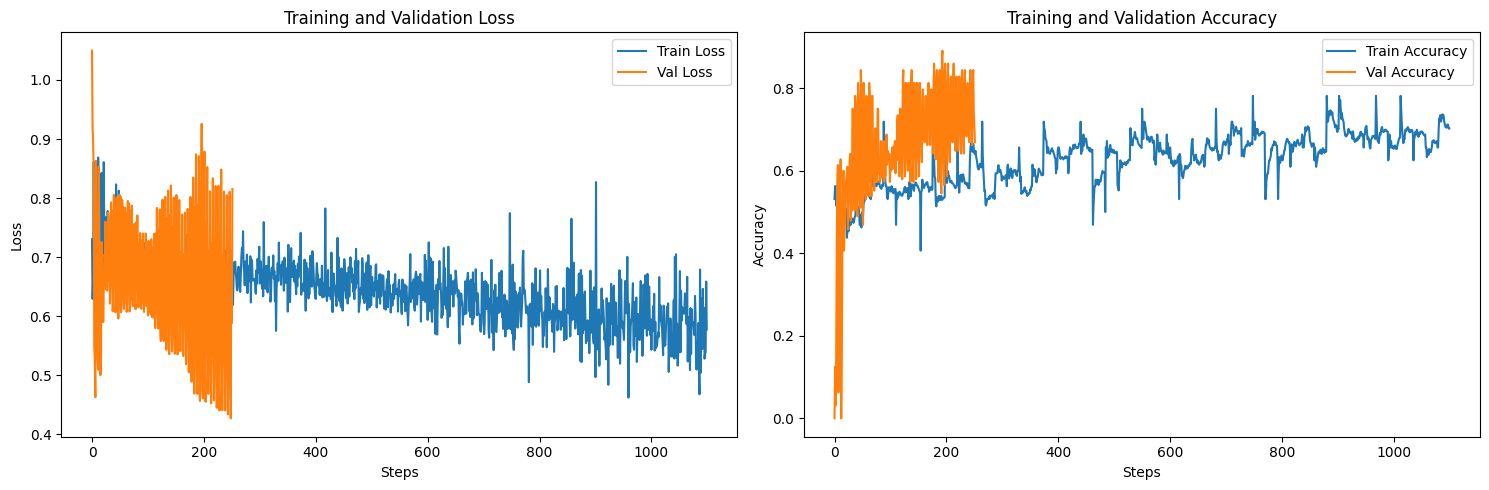

In [12]:
#%% -------- 7. Training Curves Visualization Cell --------
def plot_training_curves():
    plt.figure(figsize=(15, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(model.training_loss, label='Train Loss')
    plt.plot(model.validation_loss, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(model.training_acc, label='Train Accuracy')
    plt.plot(model.validation_acc, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves()

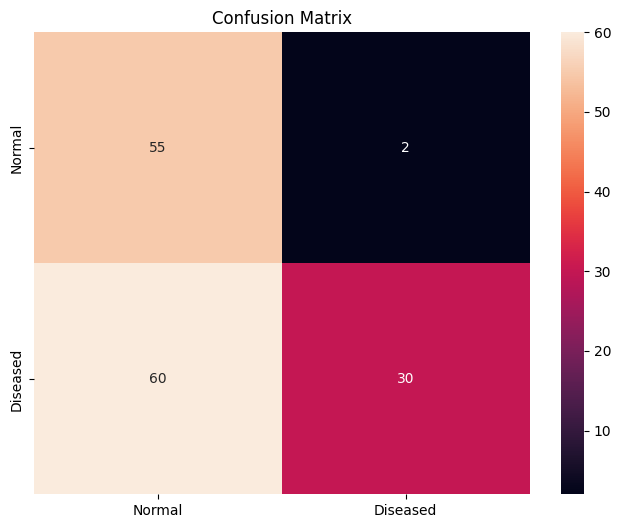

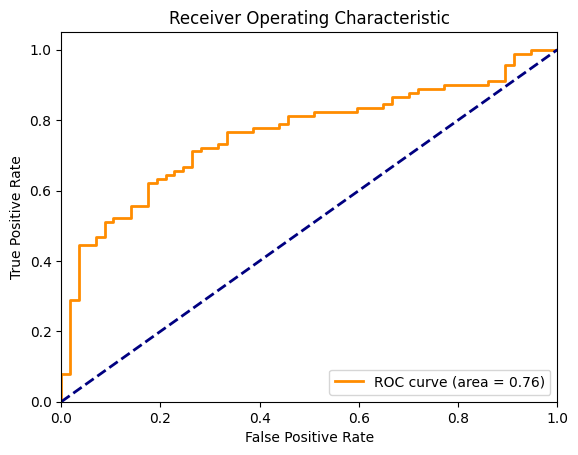

              precision    recall  f1-score   support

      Normal       0.48      0.96      0.64        57
    Diseased       0.94      0.33      0.49        90

    accuracy                           0.58       147
   macro avg       0.71      0.65      0.57       147
weighted avg       0.76      0.58      0.55       147



In [13]:
#%% -------- 8. Evaluation Cell --------
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

def evaluate():
    all_preds = []
    all_probs = []
    all_targets = []
    
    best_model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(best_model.device), y.to(best_model.device)
            probs = best_model(x)
            preds = (probs > 0.5).float()
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    print(classification_report(all_targets, all_preds, target_names=class_names))

evaluate()

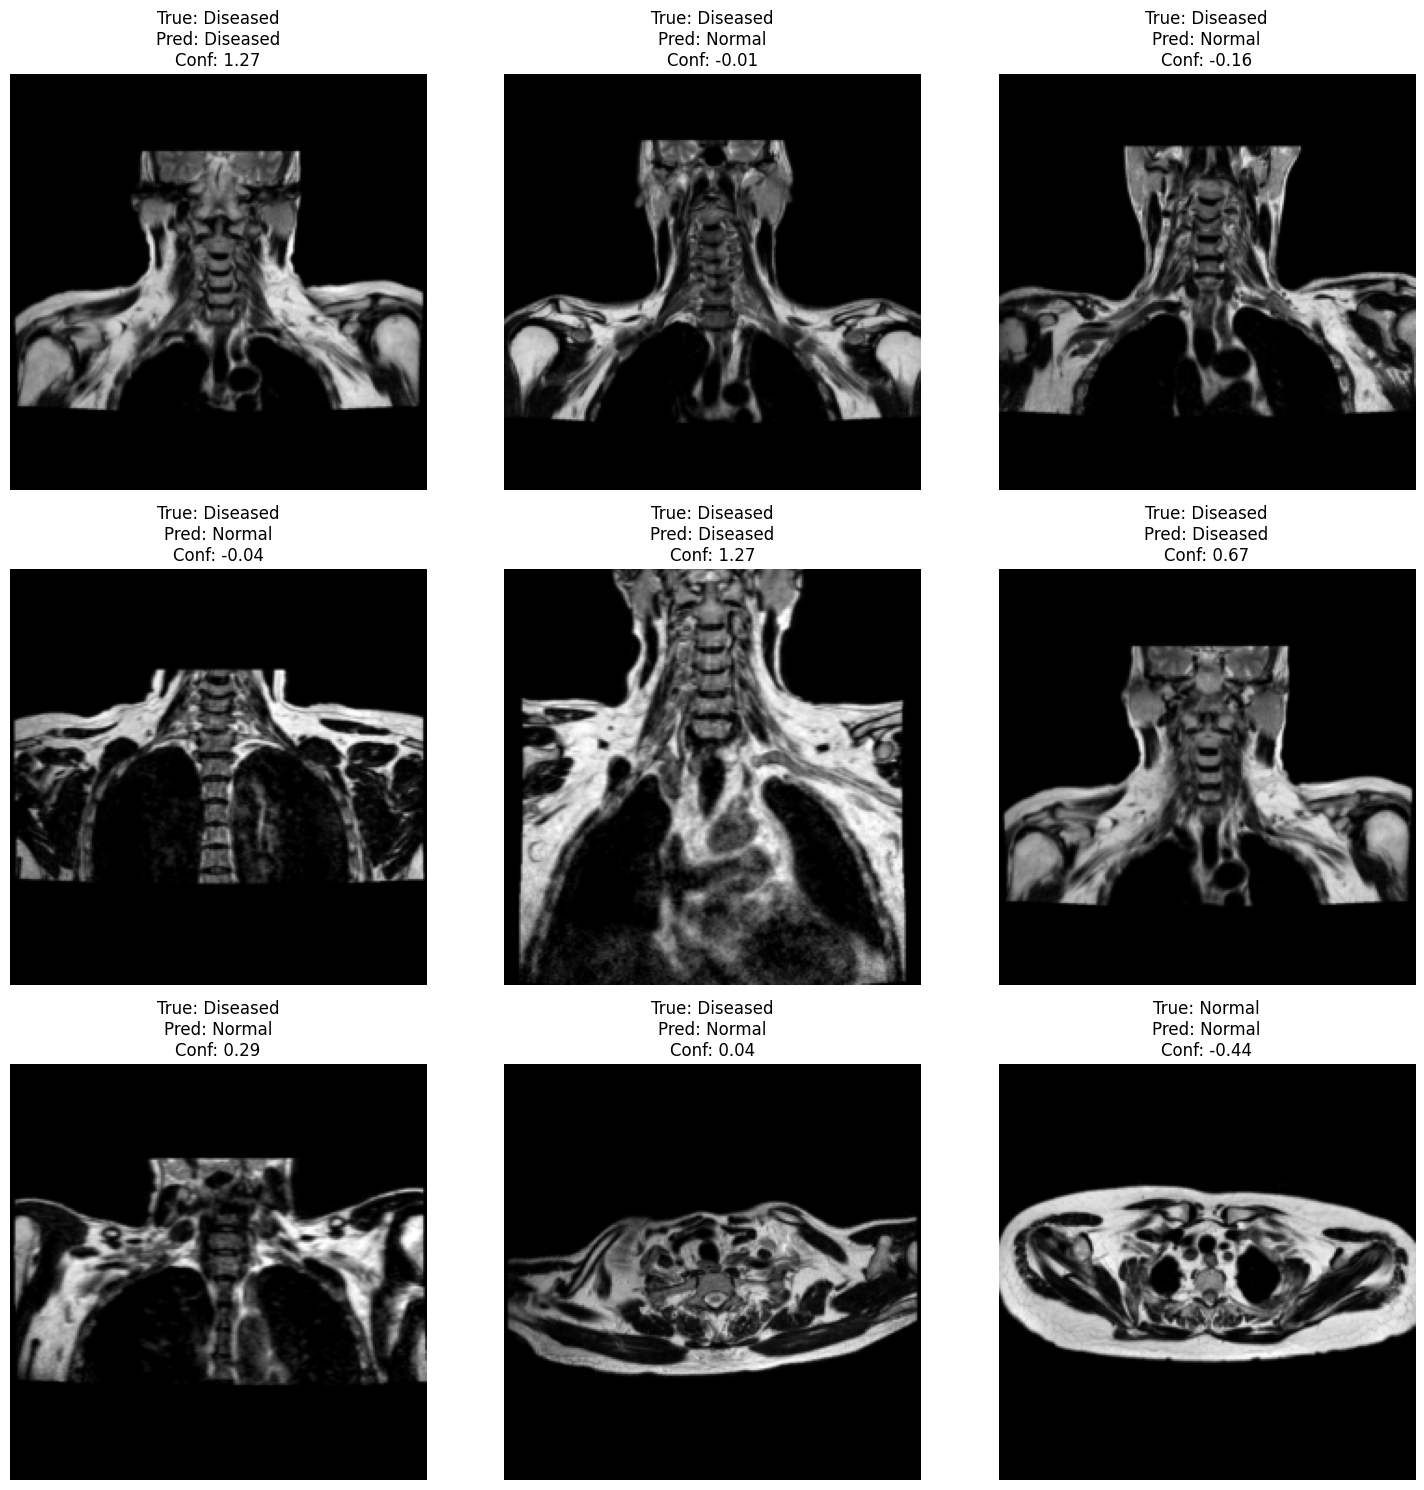

Full pipeline execution completed!


In [14]:
#%% -------- 9. Inference Visualization Cell --------
def predict_and_visualize(model, dataset, num_images=9):
    model.eval()
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, true_label = dataset[idx]
        img_tensor = img.unsqueeze(0).to(model.device)
        
        with torch.no_grad():
            prob = model(img_tensor).item()
            pred_label = int(prob > 0.5)
        
        img_np = img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
        
        plt.subplot(3, 3, i+1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {prob:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

predict_and_visualize(best_model, test_dataset)

print("Full pipeline execution completed!")